<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1620]:
from sklearn.metrics import roc_auc_score

# Первая часть. Исследование

In [1772]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1809]:
data = pd.read_csv('./train.csv')

In [1810]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [1811]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

- Мы видим, что признак 'TotalSpent' иммет тип object , хотя является float. Нужно поменять. Однако это происходит потому, что тем есть пропущенные значения в виде пробела, т.е. " ".


In [1812]:
data.loc[data['TotalSpent'] == ' ', 'TotalSpent'] = np.nan
data['TotalSpent'] = data['TotalSpent'].astype(float) # Поменяем тип
data.loc[data['TotalSpent'].isnull(), 'TotalSpent'] = data['TotalSpent'].median()
data['IsSeniorCitizen'] = data['IsSeniorCitizen'].astype(object) # Сделаем категориальную переменную, категориальной.

In [1813]:
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2289.889086,0.262022
std,24.550326,30.176464,2267.371263,0.439776
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.462500,401.587500,0.000000
50%,29.000000,70.400000,1410.250000,0.000000
75%,55.000000,90.050000,3795.212500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


- Данные без Выбросов

In [1814]:
data.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


<AxesSubplot:>

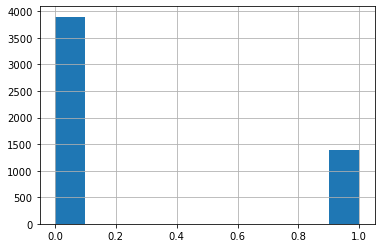

In [1815]:
data['Churn'].hist()

In [1816]:
data['Churn'].value_counts(normalize=True)

0    0.737978
1    0.262022
Name: Churn, dtype: float64

- Целевая переменная имеет дисбаланс, но не очень сильный.

#### По описательной статистике, мы видели, что на первый взгляд непрерывные признаки не имеют выбросов, для наглядности можем построить боксплоты и убедиться.

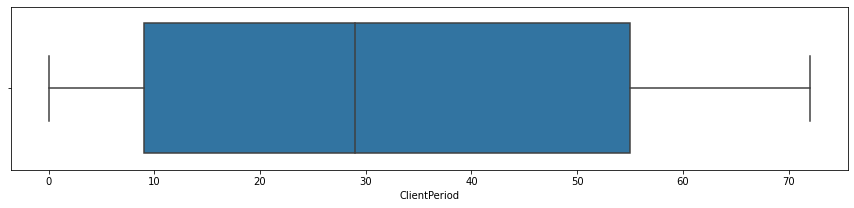

In [1817]:
plt.figure(figsize=(15,3))
sns.boxplot(data['ClientPeriod']);

- Как мы видим выбросов нет. Посмотрим  на распределение целевой переменной в разрезе 'ClientPeriod'.

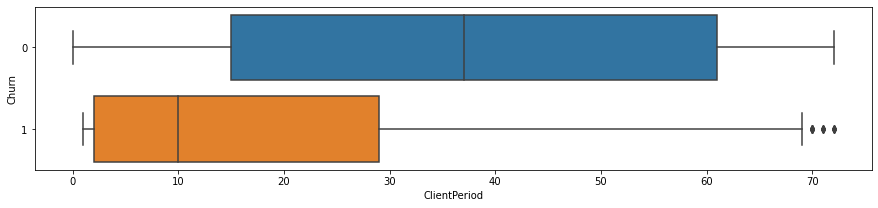

In [1818]:
plt.figure(figsize=(15,3))
sns.boxplot(x='ClientPeriod', y='Churn', data=data[['ClientPeriod', 'Churn']], orient='h');

- Как мы видим распределение явно отличается, среднее 1 класса по этому признаку смещено ближе к 0. 

''

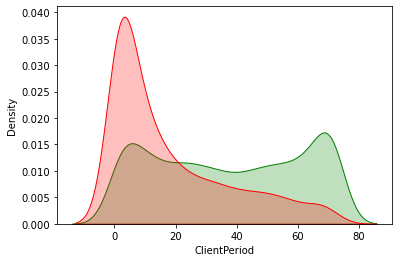

In [1819]:
churn_spread = data[['ClientPeriod', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'ClientPeriod']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'ClientPeriod']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')
;

- Исходя из наблюдений, можно сделать вывод, что люди на много чаще уходят при ClientPeriod (т.к. нет описания призноков, будем считать, что это время, которое человек провел пользуясь услугами.) близким к 0. Можно интерпритировать это, как то, что человек принимает решение,  о том, нравится ему компания или нет в первые дни. Как рекомендация, в период 0 - 20 предоставлять доп скидки.

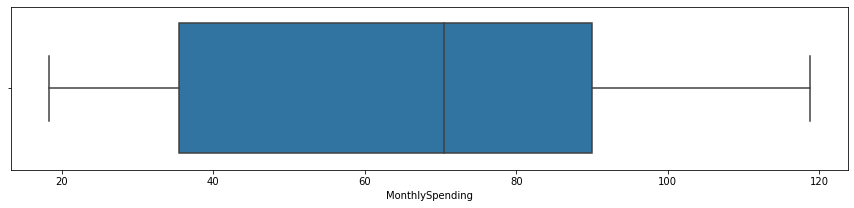

In [1820]:
plt.figure(figsize=(15,3))
sns.boxplot(data['MonthlySpending']);

- Как мы видим выбросов нет. Посмотрим  на распределение целевой переменной в разрезе 'ClientPeriod'.

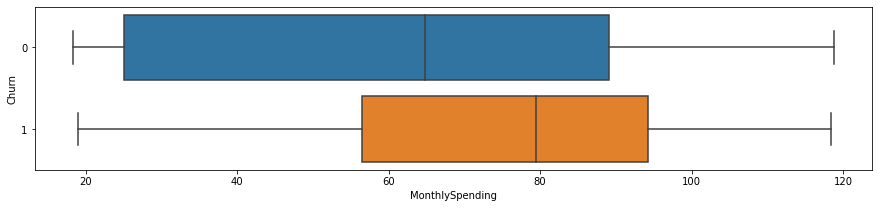

In [1821]:
plt.figure(figsize=(15,3))
sns.boxplot(x='MonthlySpending', y='Churn', data=data[['MonthlySpending', 'Churn']], orient='h');

- В целом распределение похоже, хотя средние также смещены. Посмотрим на плотность.

<AxesSubplot:xlabel='MonthlySpending', ylabel='Density'>

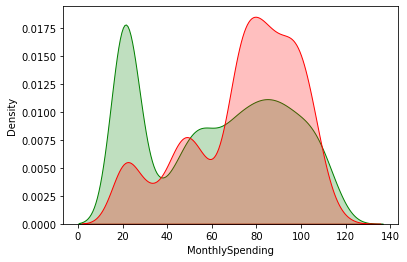

In [1822]:
churn_spread = data[['MonthlySpending', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'MonthlySpending']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'MonthlySpending']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')

- Видна прямая зависимость количества ушедших от ежемесячного расхода.

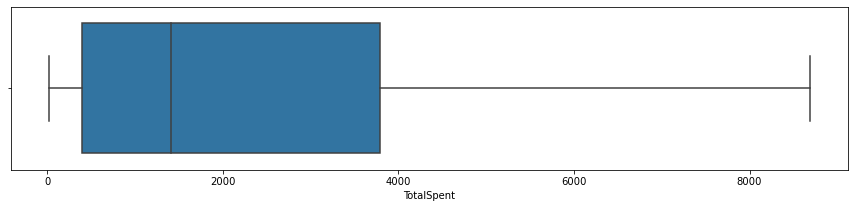

In [1823]:
plt.figure(figsize=(15,3))
sns.boxplot(data['TotalSpent']);

- Выбросов нет.

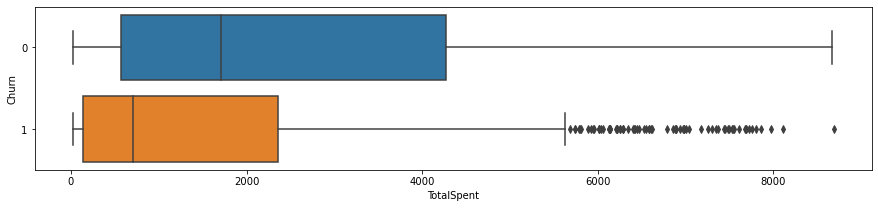

In [1824]:
plt.figure(figsize=(15,3))
sns.boxplot(x='TotalSpent', y='Churn', data=data[['TotalSpent', 'Churn']], orient='h');

<AxesSubplot:xlabel='TotalSpent', ylabel='Density'>

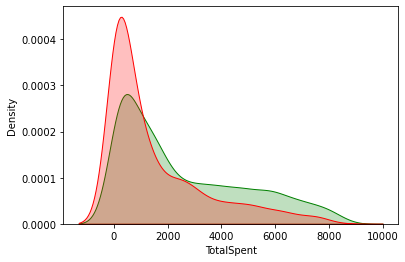

In [1825]:
churn_spread = data[['TotalSpent', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'TotalSpent']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'TotalSpent']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')

- Хоть средняя смещена, но не вижу выдающейся разницы, как на предыдущих признаках.  

In [1826]:
cols_for_pair = ['ClientPeriod','MonthlySpending', 'TotalSpent', 'Churn']

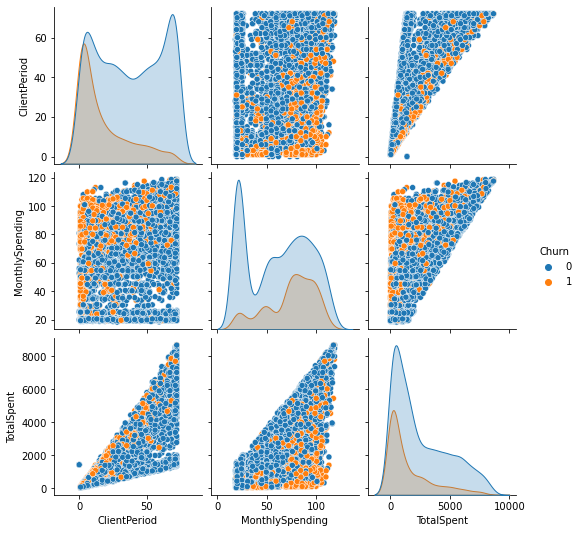

In [1827]:
sns.pairplot(data=data[cols_for_pair], hue='Churn')

- Стоит обратить внимание, на большое скопление ушедших на пересечении больших месячных расходов и малого "клиентского периода".

<AxesSubplot:>

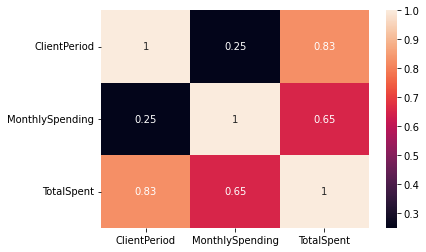

In [1828]:
sns.heatmap(data[num_cols].corr(), annot=True)

#### Посмотри категориальные признаки

In [1829]:
for cat in cat_cols:
    print(data[cat].value_counts())

Male      2655
Female    2627
Name: Sex, dtype: int64
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64
No     2705
Yes    2577
Name: HasPartner, dtype: int64
No     3676
Yes    1606
Name: HasChild, dtype: int64
Yes    4761
No      521
Name: HasPhoneService, dtype: int64
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64
No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64
No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: int64
No    

- Напишем функцию, чтобы можно было посмотреть распределение целевой переменной в каждой категории

In [1652]:
def countplot_iter(list_cat_cols, target, data):
    for i in list_cat_cols:
        yield sns.countplot(x=i, hue=target, data=data);

In [1653]:
iter = countplot_iter(cat_cols, "Churn", data)

<AxesSubplot:xlabel='Sex', ylabel='count'>

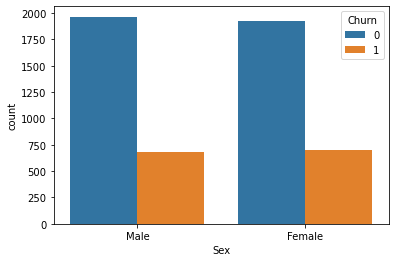

In [1654]:
next(iter)

Пролистав все признаки, самыми интересными стали 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'PaymentMethod'

- Посмотрим те, которые меня заинтересовали больше всего.

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

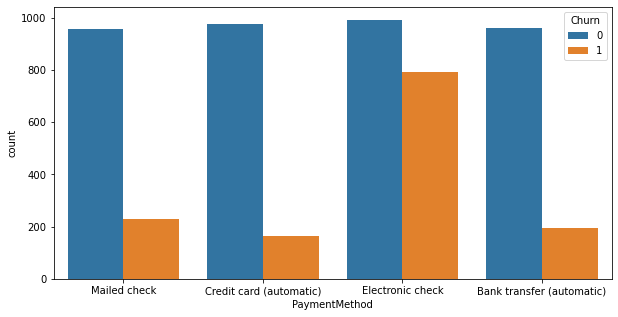

In [1655]:
plt.figure(figsize=(10,5))
sns.countplot(x='PaymentMethod', hue="Churn", data=data)

Посмотрите, как сильно выделяется распределение в подкатегории Electronic check. Можно сделать вывод, что у людей какие-то проблемы с оплатой через этот метод (возможно какйто налог или еще что). Вероятно даже имеет смысл сделать из этого признака бинарный  по подкатегории "Elecronic check" да\нет.

- Также Есть группа категориальных переменных начинающихся с Has% это означает подключенная услуга. Эти группы разделены логически на 2 подгруппы, Интернет сервисы и телефония. 

<AxesSubplot:xlabel='HasInternetService', ylabel='count'>

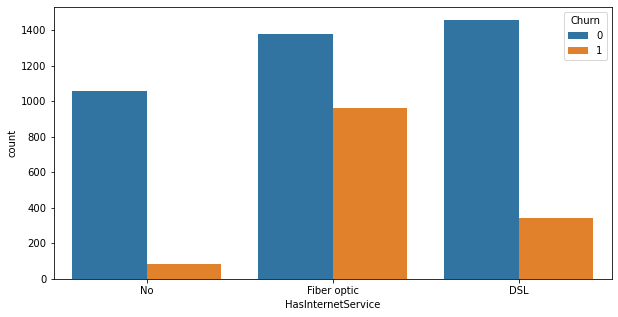

In [1505]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasInternetService', hue="Churn", data=data)

<AxesSubplot:xlabel='HasOnlineBackup', ylabel='count'>

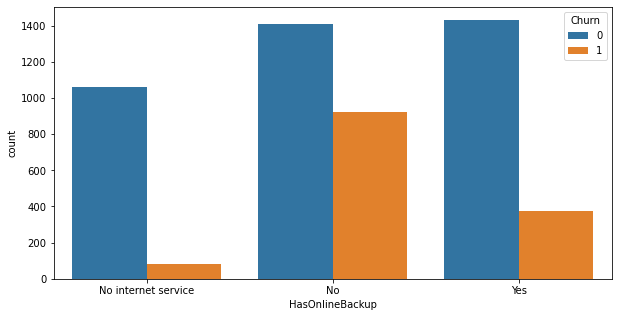

In [1506]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasOnlineBackup', hue="Churn", data=data)

<AxesSubplot:xlabel='HasDeviceProtection', ylabel='count'>

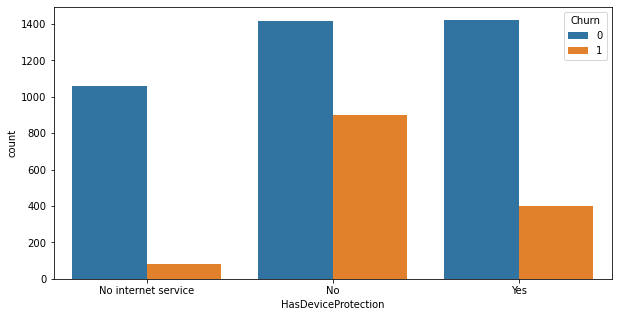

In [1507]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasDeviceProtection', hue="Churn", data=data)

In [1656]:
data.loc[data['HasInternetService'] == "No"].head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
5,25,19.80,475.20,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
18,59,19.85,1188.25,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
22,20,19.50,413.00,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),0


- Как мы видим, люди которые пользуются только телефонией, почти не отказываются от услуг.

Также еще один интересный признак 'HasTechSupportAccess', как видно из название это доступ к техподдержке.

<AxesSubplot:xlabel='HasTechSupportAccess', ylabel='count'>

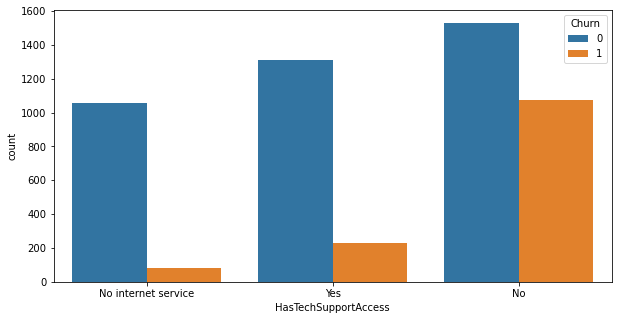

In [1509]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasTechSupportAccess', hue="Churn", data=data)

Посмотрите, какая большая разница между теми, кто не имел доступ и теми кто имел. Для маркетологов стоит задуматься, может имеет смысл сделать поддержку более "доступной".

<AxesSubplot:xlabel='HasContractPhone', ylabel='count'>

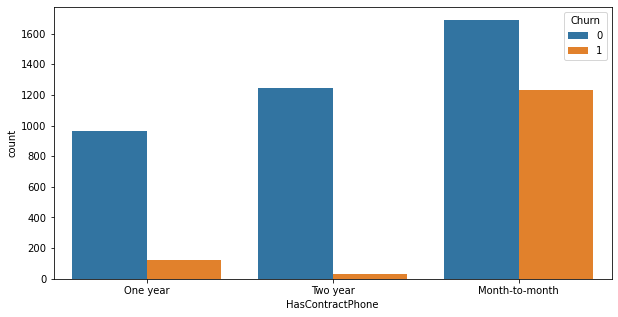

In [1510]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasContractPhone', hue="Churn", data=data)

Можно интерпритировать, это как человек который платит на год или два вперед, уверен, что он не уйдет.=)

## Строим модели

In [1657]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve

#### Сперва подготовим данные.

- Создаем дамми переменные

In [1658]:
X = pd.get_dummies(data[feature_cols], drop_first=True)
y = data[target_col]

- Разделяем на трейн \ валид выборки

In [1661]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=47)

- Стандартизируем

In [1662]:
stand = StandardScaler()

In [1663]:
X_train[num_cols] = stand.fit_transform(X_train[num_cols])
X_valid[num_cols] = stand.transform(X_valid[num_cols])

#### Теперь можно опробовать линейные модельки со стандартными параметрами.

#### № 1 LogisticRegressionCV стандарт

- Попробуем стандартную лог регрессию. По умолчанию тут используется L2 регуляризация.

In [1664]:
lrcv = LogisticRegressionCV(cv = 5, scoring='roc_auc')
lrcv.fit(X_train, y_train)

LogisticRegressionCV(cv=5, scoring='roc_auc')

In [1665]:
lrcv.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 5,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [1666]:
y_train_predicted = lrcv.predict_proba(X_train)[:, 1]
y_valid_predicted = lrcv.predict_proba(X_valid)[:, 1]

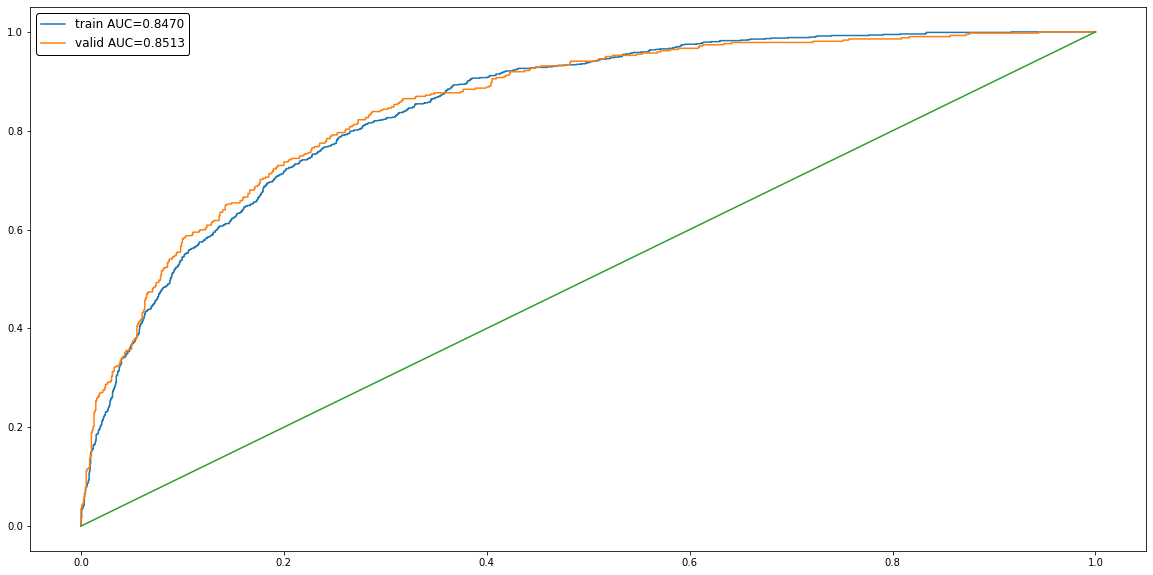

In [1667]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

- Посмотрим на веса.

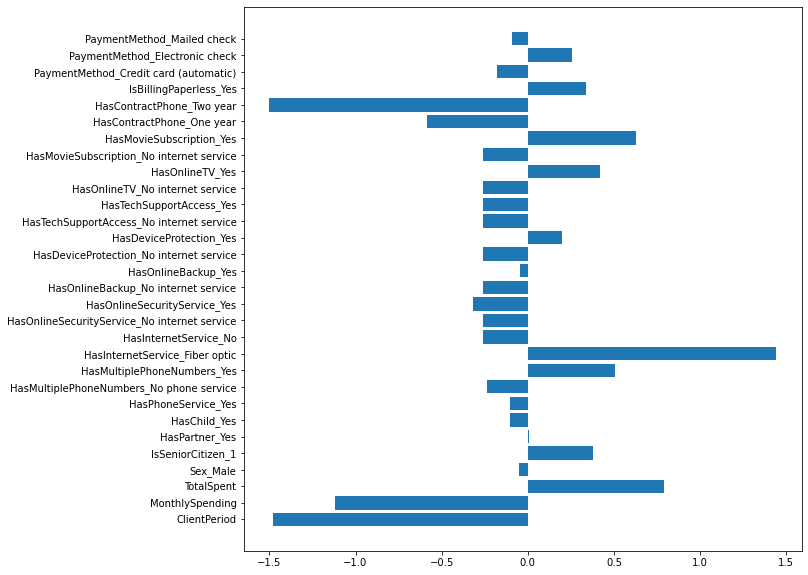

In [1668]:
f_i = lrcv.coef_[0]
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()

#### № 2 LogisticRegressionCV L1

- Попробуем тоже, но с L1 регуляризацией

In [1669]:
lrcv_l1 = LogisticRegressionCV(cv = 5, scoring='roc_auc', penalty = "l1", solver = "liblinear")
lrcv_l1.fit(X_train, y_train)

LogisticRegressionCV(cv=5, penalty='l1', scoring='roc_auc', solver='liblinear')

In [1670]:
y_train_predicted = lrcv_l1.predict_proba(X_train)[:, 1]
y_valid_predicted = lrcv_l1.predict_proba(X_valid)[:, 1]

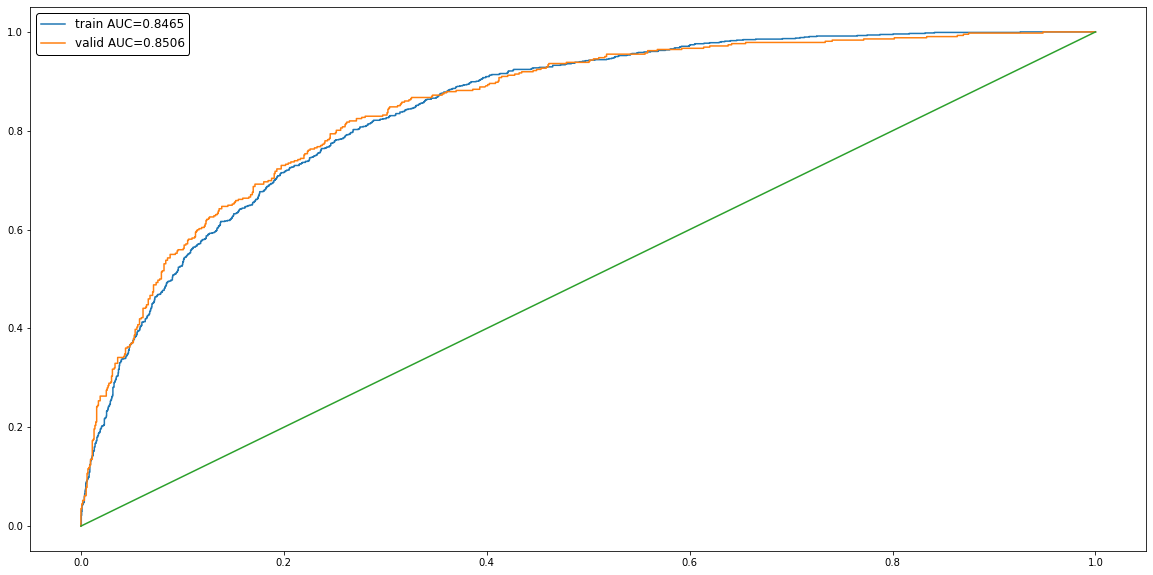

In [1671]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

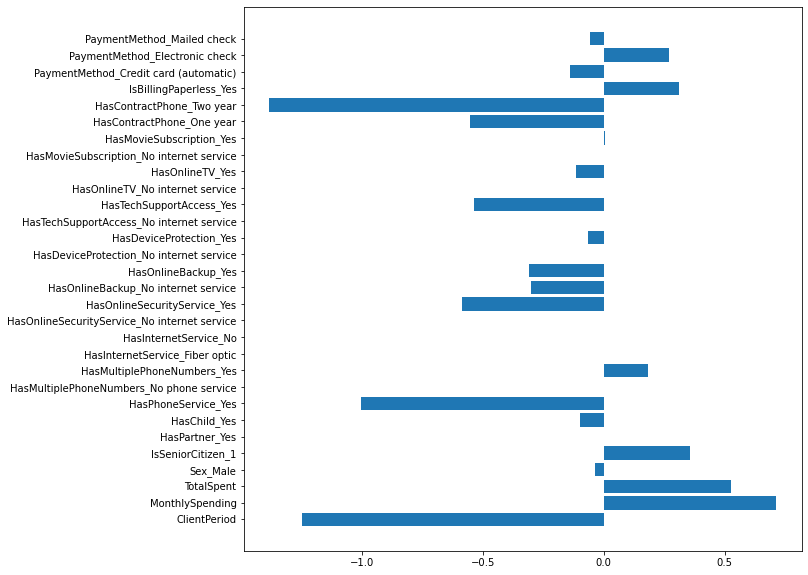

In [1672]:
f_i = lrcv_l1.coef_[0]
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()

- Можно попробовать взять только самые сильные признаки

In [1673]:
strong = ['ClientPeriod', 'TotalSpent', 'HasPhoneService_Yes', 'IsSeniorCitizen_1', 
         'IsBillingPaperless_Yes', 'HasMultiplePhoneNumbers_Yes', 'HasInternetService_Fiber optic',  'HasOnlineSecurityService_Yes', 'HasOnlineBackup_No internet service',
         'HasContractPhone_One year',
       'HasContractPhone_Two year','IsBillingPaperless_Yes']

In [1674]:
lrcv_l1.fit(X_train[strong], y_train)

LogisticRegressionCV(cv=5, penalty='l1', scoring='roc_auc', solver='liblinear')

In [1675]:
y_train_predicted = lrcv_l1.predict_proba(X_train[strong])[:, 1]
y_valid_predicted = lrcv_l1.predict_proba(X_valid[strong])[:, 1]

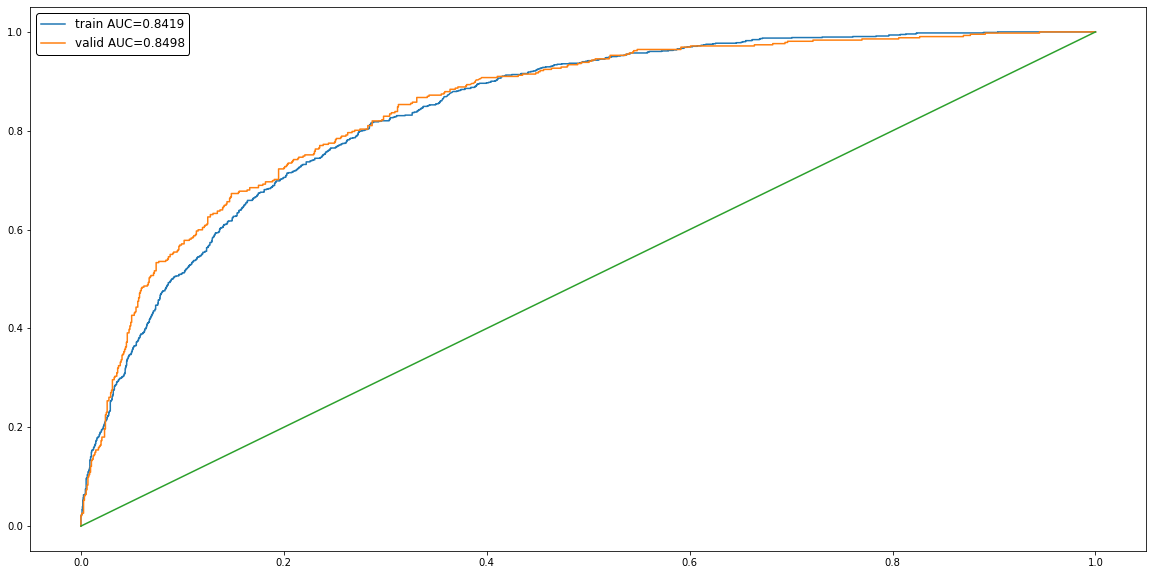

In [1676]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

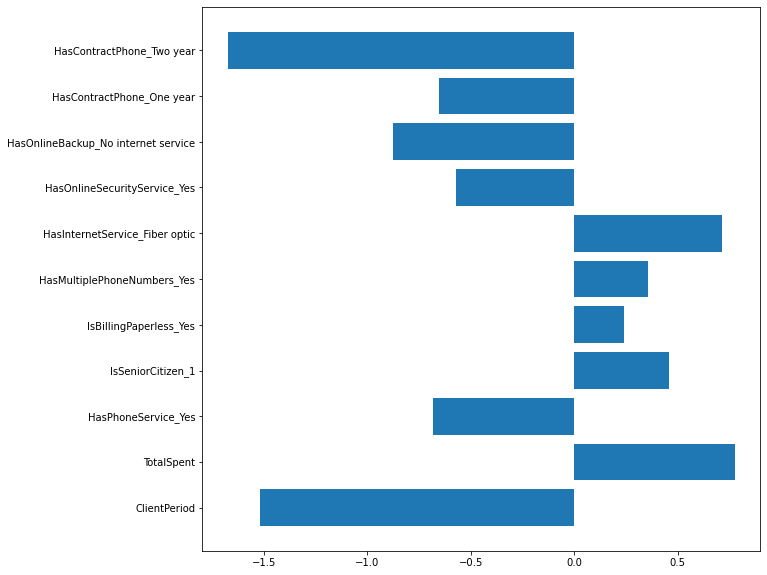

In [1677]:
f_i = lrcv_l1.coef_[0]
plt.figure(figsize=(10,10))
plt.barh(X_train[strong].columns, f_i)
plt.show()

- Не особо помогло =)

#### № 3 KNN

In [1678]:
from sklearn.neighbors import KNeighborsClassifier

In [1679]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': np.arange(25, 35),
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [1680]:
gs.fit(X_train, y_train);

In [1681]:
gs.best_params_

{'n_neighbors': 34}

In [1682]:
y_train_predicted = gs.predict_proba(X_train)[:, 1]
y_valid_predicted = gs.predict_proba(X_valid)[:, 1]

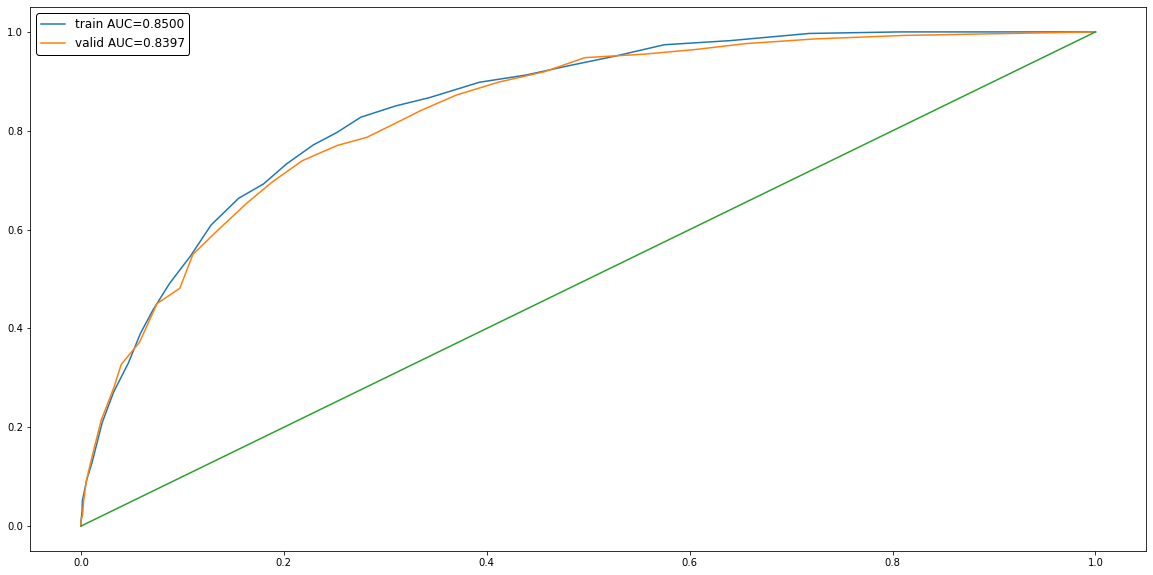

In [1683]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### № 4 SVC

In [1684]:
from sklearn.svm import SVC

In [1685]:
model = SVC(probability=True)

parameters = {
    'C': [0.01, 0.1],
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [1686]:
gs.fit(X_train, y_train);

In [1687]:
gs.best_params_

{'C': 0.01}

In [1688]:
y_train_predicted = gs.predict_proba(X_train)[:, 1]
y_valid_predicted = gs.predict_proba(X_valid)[:, 1]

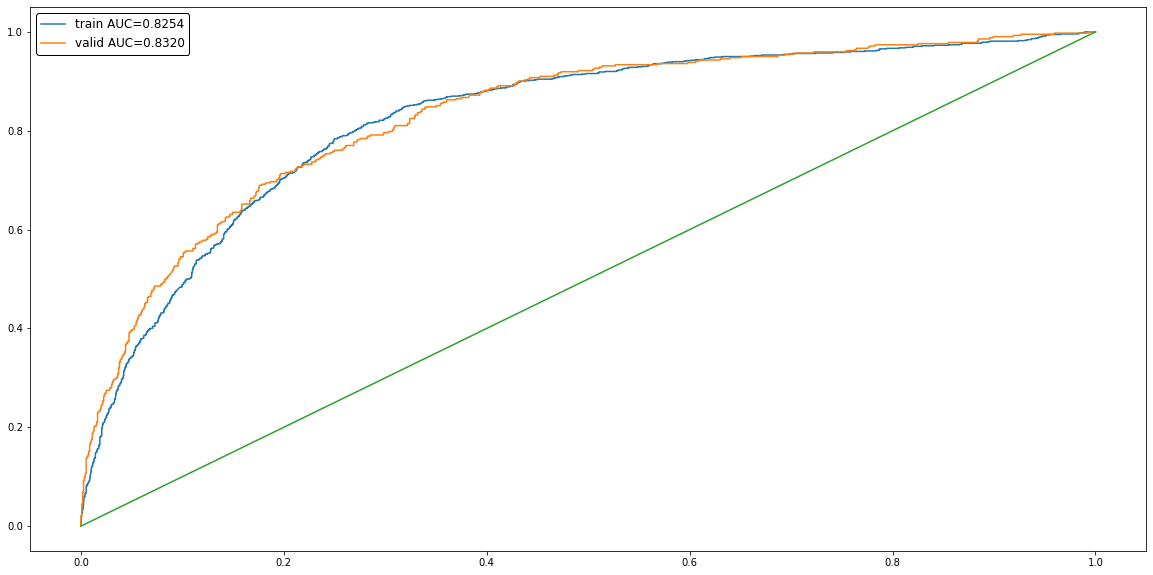

In [1689]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

- Точность оказалась по ниже, при том, что и скорость обучения такого алгоритма маловата. Попробуем использовать только сильные признаки.

In [1690]:
model = SVC(probability=True)

parameters = {
    'C': [0.01, 0.1],
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [1691]:
gs.fit(X_train[strong], y_train);
gs.best_params_

{'C': 0.01}

In [1692]:
y_train_predicted = gs.predict_proba(X_train[strong])[:, 1]
y_valid_predicted = gs.predict_proba(X_valid[strong])[:, 1]

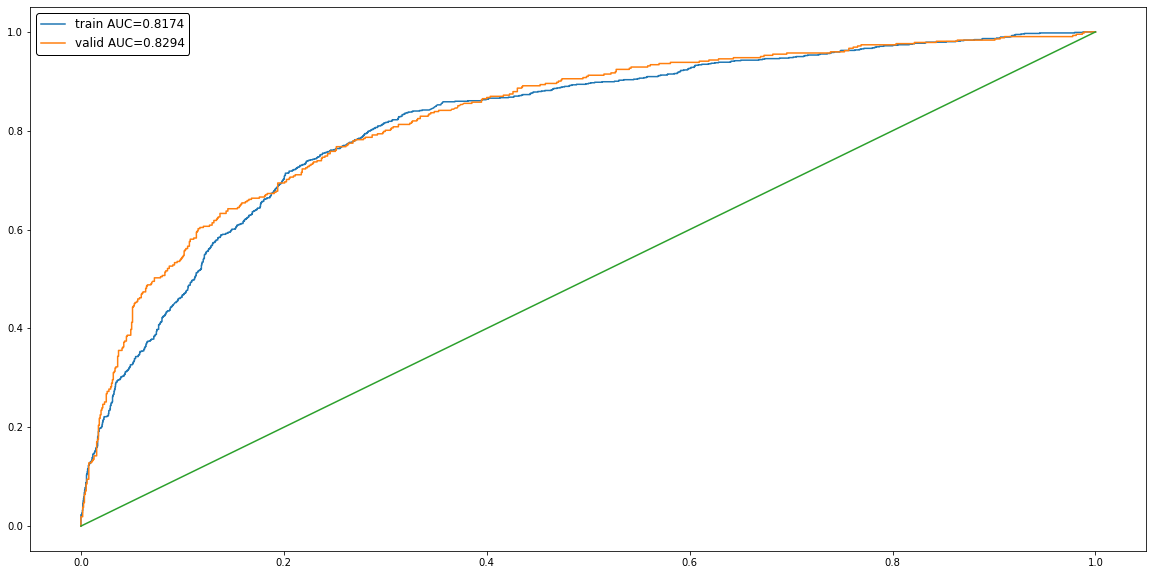

In [1693]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

- Чтож, из линейных моделей самой бодрой получилась логистическая регрессия с L1 регуляризацией.
- Параметры: LogisticRegressionCV(cv=5, penalty='l1', scoring='roc_auc', solver='liblinear')
- Качество auc_score на валидационной выборке: 0.8545

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [1694]:
from sklearn.ensemble import RandomForestClassifier
import xgboost
import catboost

#### №1 Простой лес

In [1752]:
model = RandomForestClassifier()

parameters = {
    'n_estimators': [100,200,400],
    'max_depth': [4,5],
    'max_features': ['sqrt', 'log2'],
    
     
    
    
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [1753]:
gs.fit(X_train, y_train);
gs.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}

In [1754]:
y_train_predicted = gs.predict_proba(X_train)[:, 1]
y_valid_predicted = gs.predict_proba(X_valid)[:, 1]

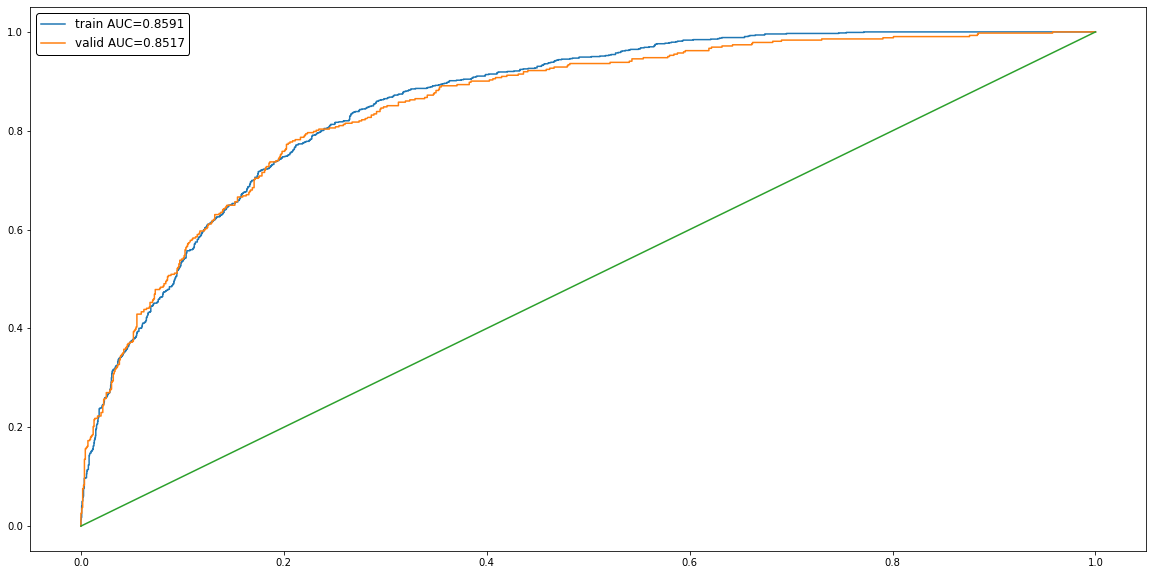

In [1755]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### №2 Xgboost

In [1743]:
model = xgboost.XGBClassifier(verbosity=0, gamma = 0.2, learning_rate = 0.09)

parameters = {
    'n_estimators': [70,150,100,200],
  'max_depth': [3,4,5,6,7,8], 

}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [1744]:
gs.fit(X_train, y_train);

In [1745]:
y_train_predicted = gs.predict_proba(X_train)[:, 1]
y_valid_predicted = gs.predict_proba(X_valid)[:, 1]

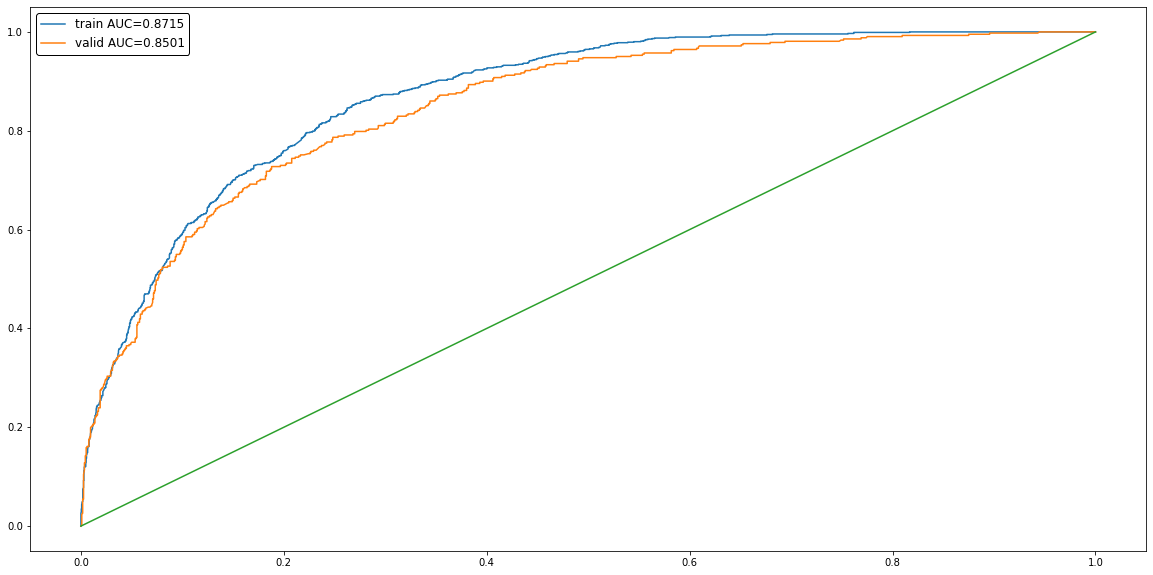

In [1746]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### №3 catboost

In [1714]:
X_train_cb, X_valid_cb, y_train, y_valid = train_test_split(data.drop("Churn", axis = 1), data['Churn'], test_size=0.3, random_state=47)

In [1715]:
boosting_model = catboost.CatBoostClassifier( 
                                             cat_features=cat_cols)


In [1716]:
boosting_model.fit(X_train_cb, y_train);

Learning rate set to 0.017993
0:	learn: 0.6807371	total: 12ms	remaining: 12s
1:	learn: 0.6702785	total: 22.3ms	remaining: 11.1s
2:	learn: 0.6608273	total: 32.2ms	remaining: 10.7s
3:	learn: 0.6508171	total: 41.7ms	remaining: 10.4s
4:	learn: 0.6400328	total: 52ms	remaining: 10.3s
5:	learn: 0.6305375	total: 61.9ms	remaining: 10.2s
6:	learn: 0.6217981	total: 72.4ms	remaining: 10.3s
7:	learn: 0.6137928	total: 80.4ms	remaining: 9.97s
8:	learn: 0.6059339	total: 91.7ms	remaining: 10.1s
9:	learn: 0.5987913	total: 99.7ms	remaining: 9.87s
10:	learn: 0.5907022	total: 110ms	remaining: 9.88s
11:	learn: 0.5837680	total: 119ms	remaining: 9.82s
12:	learn: 0.5777033	total: 125ms	remaining: 9.45s
13:	learn: 0.5715485	total: 151ms	remaining: 10.7s
14:	learn: 0.5660138	total: 166ms	remaining: 10.9s
15:	learn: 0.5590873	total: 176ms	remaining: 10.8s
16:	learn: 0.5541856	total: 182ms	remaining: 10.5s
17:	learn: 0.5494981	total: 190ms	remaining: 10.4s
18:	learn: 0.5439354	total: 200ms	remaining: 10.3s
19:	lea

171:	learn: 0.3963293	total: 2.44s	remaining: 11.8s
172:	learn: 0.3962365	total: 2.46s	remaining: 11.8s
173:	learn: 0.3962178	total: 2.47s	remaining: 11.7s
174:	learn: 0.3961057	total: 2.48s	remaining: 11.7s
175:	learn: 0.3957218	total: 2.51s	remaining: 11.7s
176:	learn: 0.3955315	total: 2.52s	remaining: 11.7s
177:	learn: 0.3953092	total: 2.54s	remaining: 11.8s
178:	learn: 0.3952221	total: 2.58s	remaining: 11.9s
179:	learn: 0.3950806	total: 2.6s	remaining: 11.8s
180:	learn: 0.3949262	total: 2.61s	remaining: 11.8s
181:	learn: 0.3947794	total: 2.62s	remaining: 11.8s
182:	learn: 0.3947790	total: 2.62s	remaining: 11.7s
183:	learn: 0.3945557	total: 2.63s	remaining: 11.7s
184:	learn: 0.3943489	total: 2.65s	remaining: 11.7s
185:	learn: 0.3942046	total: 2.66s	remaining: 11.6s
186:	learn: 0.3940283	total: 2.67s	remaining: 11.6s
187:	learn: 0.3938033	total: 2.68s	remaining: 11.6s
188:	learn: 0.3937082	total: 2.69s	remaining: 11.6s
189:	learn: 0.3936313	total: 2.7s	remaining: 11.5s
190:	learn: 0.

332:	learn: 0.3806138	total: 4.61s	remaining: 9.24s
333:	learn: 0.3805904	total: 4.63s	remaining: 9.22s
334:	learn: 0.3805853	total: 4.63s	remaining: 9.19s
335:	learn: 0.3805840	total: 4.63s	remaining: 9.16s
336:	learn: 0.3805373	total: 4.64s	remaining: 9.14s
337:	learn: 0.3803711	total: 4.67s	remaining: 9.15s
338:	learn: 0.3803295	total: 4.69s	remaining: 9.15s
339:	learn: 0.3802471	total: 4.7s	remaining: 9.13s
340:	learn: 0.3801347	total: 4.72s	remaining: 9.11s
341:	learn: 0.3799741	total: 4.74s	remaining: 9.12s
342:	learn: 0.3799741	total: 4.74s	remaining: 9.08s
343:	learn: 0.3799268	total: 4.76s	remaining: 9.08s
344:	learn: 0.3798298	total: 4.78s	remaining: 9.07s
345:	learn: 0.3797613	total: 4.79s	remaining: 9.05s
346:	learn: 0.3796301	total: 4.8s	remaining: 9.04s
347:	learn: 0.3795740	total: 4.82s	remaining: 9.02s
348:	learn: 0.3795286	total: 4.83s	remaining: 9s
349:	learn: 0.3794583	total: 4.84s	remaining: 8.98s
350:	learn: 0.3794198	total: 4.84s	remaining: 8.95s
351:	learn: 0.379

503:	learn: 0.3673725	total: 7.01s	remaining: 6.9s
504:	learn: 0.3673035	total: 7.02s	remaining: 6.88s
505:	learn: 0.3672112	total: 7.03s	remaining: 6.86s
506:	learn: 0.3671223	total: 7.04s	remaining: 6.85s
507:	learn: 0.3671174	total: 7.06s	remaining: 6.84s
508:	learn: 0.3670791	total: 7.07s	remaining: 6.82s
509:	learn: 0.3670588	total: 7.08s	remaining: 6.8s
510:	learn: 0.3668818	total: 7.12s	remaining: 6.81s
511:	learn: 0.3667673	total: 7.14s	remaining: 6.81s
512:	learn: 0.3665683	total: 7.15s	remaining: 6.79s
513:	learn: 0.3664794	total: 7.16s	remaining: 6.77s
514:	learn: 0.3663663	total: 7.17s	remaining: 6.76s
515:	learn: 0.3663564	total: 7.21s	remaining: 6.76s
516:	learn: 0.3662192	total: 7.23s	remaining: 6.75s
517:	learn: 0.3661748	total: 7.25s	remaining: 6.75s
518:	learn: 0.3660952	total: 7.29s	remaining: 6.76s
519:	learn: 0.3660795	total: 7.3s	remaining: 6.74s
520:	learn: 0.3660023	total: 7.31s	remaining: 6.72s
521:	learn: 0.3659464	total: 7.33s	remaining: 6.71s
522:	learn: 0.3

668:	learn: 0.3523469	total: 9.66s	remaining: 4.78s
669:	learn: 0.3523020	total: 9.67s	remaining: 4.76s
670:	learn: 0.3522243	total: 9.68s	remaining: 4.75s
671:	learn: 0.3521633	total: 9.69s	remaining: 4.73s
672:	learn: 0.3521453	total: 9.7s	remaining: 4.71s
673:	learn: 0.3520567	total: 9.71s	remaining: 4.7s
674:	learn: 0.3519313	total: 9.73s	remaining: 4.69s
675:	learn: 0.3518320	total: 9.74s	remaining: 4.67s
676:	learn: 0.3517410	total: 9.76s	remaining: 4.65s
677:	learn: 0.3515870	total: 9.77s	remaining: 4.64s
678:	learn: 0.3514272	total: 9.78s	remaining: 4.62s
679:	learn: 0.3512508	total: 9.79s	remaining: 4.61s
680:	learn: 0.3512428	total: 9.8s	remaining: 4.59s
681:	learn: 0.3511354	total: 9.81s	remaining: 4.57s
682:	learn: 0.3509642	total: 9.82s	remaining: 4.56s
683:	learn: 0.3507928	total: 9.83s	remaining: 4.54s
684:	learn: 0.3506797	total: 9.84s	remaining: 4.52s
685:	learn: 0.3506178	total: 9.86s	remaining: 4.51s
686:	learn: 0.3504730	total: 9.89s	remaining: 4.51s
687:	learn: 0.3

827:	learn: 0.3396294	total: 11.9s	remaining: 2.47s
828:	learn: 0.3396253	total: 11.9s	remaining: 2.45s
829:	learn: 0.3396005	total: 11.9s	remaining: 2.44s
830:	learn: 0.3395799	total: 11.9s	remaining: 2.42s
831:	learn: 0.3394507	total: 11.9s	remaining: 2.41s
832:	learn: 0.3392162	total: 12s	remaining: 2.4s
833:	learn: 0.3390878	total: 12s	remaining: 2.38s
834:	learn: 0.3389666	total: 12s	remaining: 2.37s
835:	learn: 0.3389455	total: 12s	remaining: 2.35s
836:	learn: 0.3389114	total: 12s	remaining: 2.34s
837:	learn: 0.3388162	total: 12s	remaining: 2.32s
838:	learn: 0.3386915	total: 12s	remaining: 2.31s
839:	learn: 0.3385951	total: 12s	remaining: 2.29s
840:	learn: 0.3384663	total: 12.1s	remaining: 2.28s
841:	learn: 0.3383804	total: 12.1s	remaining: 2.26s
842:	learn: 0.3382786	total: 12.1s	remaining: 2.25s
843:	learn: 0.3382638	total: 12.1s	remaining: 2.23s
844:	learn: 0.3382599	total: 12.1s	remaining: 2.22s
845:	learn: 0.3382361	total: 12.1s	remaining: 2.21s
846:	learn: 0.3382036	total: 

993:	learn: 0.3268318	total: 14.5s	remaining: 87.7ms
994:	learn: 0.3267553	total: 14.6s	remaining: 73.2ms
995:	learn: 0.3266209	total: 14.6s	remaining: 58.6ms
996:	learn: 0.3265618	total: 14.6s	remaining: 44ms
997:	learn: 0.3264426	total: 14.6s	remaining: 29.3ms
998:	learn: 0.3264240	total: 14.6s	remaining: 14.6ms
999:	learn: 0.3263126	total: 14.6s	remaining: 0us


In [1717]:
y_train_predicted = boosting_model.predict_proba(X_train_cb)[:, 1]
y_valid_predicted = boosting_model.predict_proba(X_valid_cb)[:, 1]

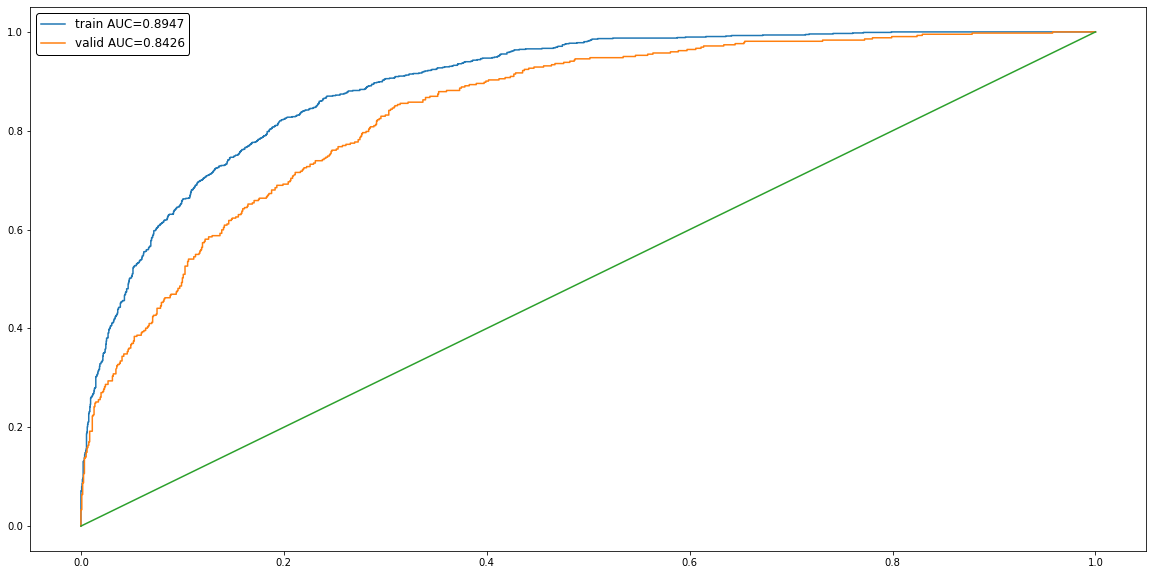

In [1718]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

- Из деревьев получилось, что катбуст лучше всех справился. 
- Параметры модели по умолчанию
- Точность на валидационной выборке 0.8532


# Предсказания

Заново загрузим и обработает данные.

In [1839]:
data = pd.read_csv('./train.csv')
TotalSpent_median = 0

In [1840]:
def prepare_data_train(df):
    df.loc[df['TotalSpent'] == ' ', 'TotalSpent'] = np.nan
    df['TotalSpent'] = df['TotalSpent'].astype(float) # Поменяем тип
    TotalSpent_median = df['TotalSpent'].median()
    df.loc[df['TotalSpent'].isnull(), 'TotalSpent'] = TotalSpent_median
    df['IsSeniorCitizen'] = df['IsSeniorCitizen'].astype(object) # Сделаем категориальную переменную, категориальной.
    X = pd.get_dummies(df[feature_cols], drop_first=True)
    return X

In [1841]:
def prepare_data_test(df):
    df.loc[df['TotalSpent'] == ' ', 'TotalSpent'] = np.nan
    df['TotalSpent'] = df['TotalSpent'].astype(float) # Поменяем тип
    df.loc[df['TotalSpent'].isnull(), 'TotalSpent'] = TotalSpent_median
    df['IsSeniorCitizen'] = df['IsSeniorCitizen'].astype(object) # Сделаем категориальную переменную, категориальной.
    X = pd.get_dummies(df[feature_cols], drop_first=True)
    return X

In [1842]:
X_train = prepare_data_train(data)
y_train = data['Churn']

Обучим лидера.

In [1843]:
best_model = RandomForestClassifier(max_depth = 5, max_features = 'sqrt', n_estimators = 200)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=200)

In [1844]:
X_test = pd.read_csv('./test.csv')

In [1845]:
X_test = prepare_data_test(X_test)

In [1846]:
submission = pd.read_csv('./submission.csv')

In [1864]:
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]

In [1866]:
submission.to_csv('./my_submission.csv', index = False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.